## За аналог взят

[Распознавание рукописного ввода с использованием CRNN в Керасе](https://www.kaggle.com/samfc10/handwriting-recognition-using-crnn-in-keras)

In [59]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

In [60]:
import sys
sys.path.append('..')

from scr import train
data_path_train = '../data/dataset/dataset/training_data'
data_path_test = '../data/dataset/dataset/testing_data'
images_path_train = '../data/dataset/dataset/training_data/images'
images_path_test = '../data/dataset/dataset/testing_data/images'

In [61]:
def open_anatac(path):
    df = train.Train().get_annotation(path, True)
    df = df.drop_duplicates('fil_name')
    df = df.sort_values('fil_name', ignore_index = True)
    return df

In [62]:
train_df = open_anatac(data_path_train)
train_size = train_df.shape[0]
print(train_size)
train_df.head()

125


,box,text,label,words,linking,id,fil_name
0,"[525, 904, 641, 926]",597005708,other,"[{'box': [525, 904, 641, 926], 'text': '597005...",[],8,0000971160
1,"[533, 829, 653, 853]",620419245,other,"[{'box': [533, 829, 653, 853], 'text': '620419...",[],29,0000989556
2,"[501, 839, 623, 871]",620429480,other,"[{'box': [501, 839, 623, 871], 'text': '620429...",[],10,0000990274
3,"[550, 883, 675, 904]",620915734,other,"[{'box': [550, 883, 675, 904], 'text': '620915...",[],119,0000999294
4,"[697, 796, 721, 927]",621800455,other,"[{'box': [697, 796, 721, 927], 'text': '621800...",[],3,0001118259


In [63]:
test_df = open_anatac(data_path_test)
test_size = test_df.shape[0]
print(test_size)
test_df.head()

49


C:\Users\uriks\PycharmProjects\Identification-of-drawings\notebooks\..\scr\train.py:105: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return (df.label == 'other')&(df.text.str.contains('(^\d{5,10})|(\d{5,10}$)'))


,box,text,label,words,linking,id,fil_name
0,"[633, 775, 653, 874]",82092117,other,"[{'box': [633, 775, 653, 874], 'text': '820921...",[],6,82092117
1,"[675, 774, 696, 879]",82200067,other,"[{'box': [675, 774, 696, 879], 'text': '822000...",[],22,82200067_0069
2,"[680, 814, 698, 917]",82250337,other,"[{'box': [680, 814, 698, 917], 'text': '822503...",[],11,82250337_0338
3,"[680, 832, 702, 941]",82251504,other,"[{'box': [680, 832, 702, 941], 'text': '822515...",[],10,82251504
4,"[695, 787, 719, 895]",82252956,other,"[{'box': [695, 787, 719, 895], 'text': '822529...",[],12,82252956_2958


## Уникальные символы которые мы хотим распознать

In [64]:
sym_list = []

for text in  train_df.text:
    for word in text:
        word = word.upper()
        if word not in sym_list: 
            sym_list.append(word)
sym_list.sort()
alphabets = ''.join(sym_list)
print(sym_list)
alphabets

[' ', '&', ',', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'J', 'K', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'W', 'X', 'Y']


' &,.0123456789ABCDEFGIJKMNOPRSTUWXY'

## Максимальная длинна строки

In [65]:
max_str_len = train_df.text.str.len().max()
max_str_len

38

## Предварительная обработка и подготовка изображений к обучению

* Изображения загружаются в оттенках серого и меняют форму на ширину 256 и высоту 64.
* Ширина и высота обрезаются, если они больше 256 и 64 соответственно.  
* Если они меньше, то изображение дополняется белыми пикселями.  
* Наконец, изображение поворачивается по часовой стрелке, чтобы привести форму изображения к (x, y).
* Затем изображение нормализуется до диапазона [0, 1].

In [93]:
h_max, w_max = 1024, 768
# h_max, w_max = 256, 64

In [94]:
def preprocess(img):
    h_max, w_max = 1024, 768
#     h_max, w_max = 256, 64
    
    (h, w) = img.shape
    
    final_img = np.ones([h_max, w_max])*255 # blank white image
    
    # crop
    if w > w_max:
        img = img[:, :w_max]
        
    if h > h_max:
        img = img[:h_max, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [95]:
def lod_imag(df, images_path):
    data = []
    targets = []
    filenames = []

    for name in df.fil_name.unique():
        filename = name + '.png'
        image_path = f'{images_path}/{filename}'
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = preprocess(image)
        image = image/255

        data.append(image)
        targets.append(train_df.loc[train_df.fil_name == name, 'text'].max())
        filenames = [filename]
    return data, targets, filenames

In [96]:
train_x, train_targets, train_filenames = lod_imag(train_df, images_path_train)
test_x, test_targets, test_filenames = lod_imag(test_df, images_path_test)

In [97]:
train_x = np.array(train_x).reshape(-1, h_max, w_max, 1)
test_x = np.array(test_x).reshape(-1, h_max, w_max, 1)

## Подготовка этикеток для CTC Loss¶

 Узнайте больше о потере CTC и о том, почему это потрясающе для распознавания текста [здесь](https://theailearner.com/2019/05/29/connectionist-temporal-classificationctc/).

 Метки должны быть преобразованы в числа, которые представляют каждый символ в обучающем наборе.  «Алфавиты» состоят из AZ и трех специальных символов (- и пробела).

In [98]:
alphabets = alphabets #Уникальные символы которые мы хотим распознать
print('alphabets = ', alphabets)
max_str_len = max_str_len # Максимальная длинна строки
print('max_str_len = ', max_str_len)
num_of_characters = len(alphabets) + 1 # +1 для псевдо-пустого ctc
print('num_of_characters = ', num_of_characters)
num_of_timestamps = 64 # максимальная длина прогнозируемых меток
print('num_of_timestamps = ', num_of_timestamps)

def label_to_num(label):
    label_num = []
    for ch in label:
        ch = ch.upper()
        label_num.append(alphabets.find(ch))
#         print(ch, alphabets.find(ch))
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

alphabets =   &,.0123456789ABCDEFGIJKMNOPRSTUWXY
max_str_len =  38
num_of_characters =  36
num_of_timestamps =  64


In [99]:
text = '93329540'
print(text, '\n',label_to_num(text))

93329540 
 [13  7  7  6 13  9  8  4]


* train_y содержит истинные метки, преобразованные в числа и дополненные -1.  Длина каждой метки равна max_str_len.
* train_label_len содержит длину каждой истинной метки (без заполнения)
* train_input_len содержит длину каждой прогнозируемой метки.  Длина всех прогнозируемых меток постоянна, т.е. количество временных меток - 2.
* train_output фиктивный вывод для потери ctc.

In [100]:
def get_labls(df, size, max_str_len):
#     y = np.ones([size, max_str_len]) * 0
    y = np.ones([size, max_str_len]) * -1
    label_len = np.zeros([size, 1])
    input_len = np.ones([size, 1]) * (num_of_timestamps-2)
    output = np.zeros([size])

    for i in range(size):
        label_len[i] = len(df.loc[i, 'text'])
        row = label_to_num(df.loc[i, 'text'])
        y[i, 0:len(df.loc[i, 'text'])] = row
#         print(df.loc[i, 'text'], '\t', y[i, 0:len(df.loc[i, 'text'])])
#     print(y.shape)
    return y, label_len, input_len, output

In [101]:
train_y, train_label_len, train_input_len, train_output = get_labls(train_df, train_size, max_str_len = max_str_len)
test_y, test_label_len, test_input_len, test_output = get_labls(test_df, test_size, max_str_len = max_str_len)

In [102]:
train_x.shape

(125, 1024, 768, 1)

In [103]:
 h_max, w_max

(1024, 768)

(125, 256, 64, 1)

(256, 64)

ValueError: total size of new array must be unchanged, input_shape = [256, 96, 128], output_shape = [64, 1024]

In [105]:
input_data = Input(shape=(1024, 768, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

ValueError: total size of new array must be unchanged, input_shape = [256, 96, 128], output_shape = [64, 1024]

In [44]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [45]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [51]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))

model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([test_x, test_y, test_input_len, test_label_len], test_output),
                epochs=30, batch_size=128)

Epoch 1/30
1/1 [==============================] - 13s 13s/step - loss: 36.9065 - val_loss: 37.8891
Epoch 2/30
1/1 [==============================] - 5s 5s/step - loss: 36.3467 - val_loss: 34.9299
Epoch 3/30
1/1 [==============================] - 5s 5s/step - loss: 36.4567 - val_loss: 34.7195
Epoch 4/30
1/1 [==============================] - 5s 5s/step - loss: 36.1326 - val_loss: 35.6781
Epoch 5/30
1/1 [==============================] - 6s 6s/step - loss: 35.7753 - val_loss: 36.8615
Epoch 6/30
1/1 [==============================] - 6s 6s/step - loss: 35.6634 - val_loss: 37.2000
Epoch 7/30
1/1 [==============================] - 6s 6s/step - loss: 35.6545 - val_loss: 36.2590
Epoch 8/30
1/1 [==============================] - 6s 6s/step - loss: 35.5929 - val_loss: 34.4403
Epoch 9/30
1/1 [==============================] - 6s 6s/step - loss: 35.3895 - val_loss: 32.4134
Epoch 10/30
1/1 [==============================] - 6s 6s/step - loss: 35.1944 - val_loss: 30.7133
Epoch 11/30
1/1 [==========

## Проверить производительность модели на наборе для валидации

In [52]:
preds = model.predict(test_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(test_size):
    prediction.append(num_to_label(decoded[i]))

In [53]:
y_true = test_df.loc[0:test_size, 'text']
correct_char = 0
total_char = 0
correct = 0

for i in range(test_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/test_size))

Correct characters predicted : 0.00%
Correct words predicted      : 0.00%


## Некоторые прогнозы на тестовой выборке

Ответ:  


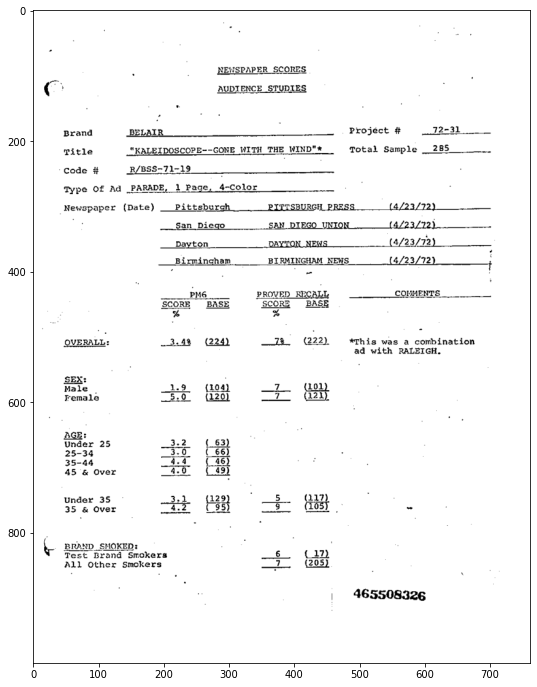

Ответ:  


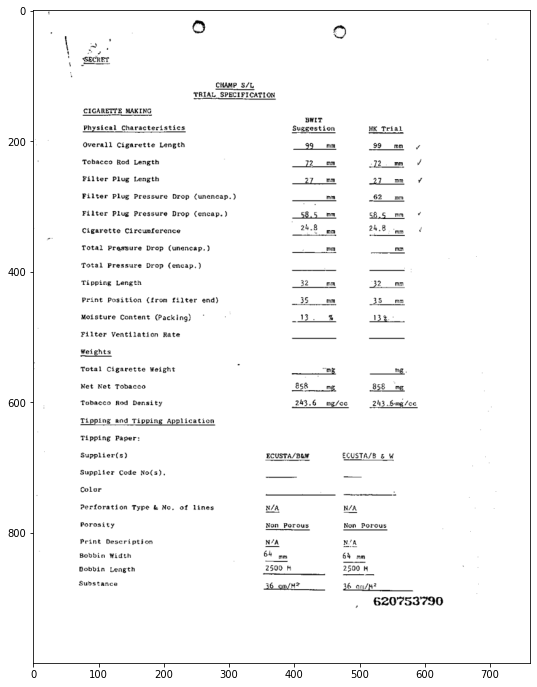

Ответ:  


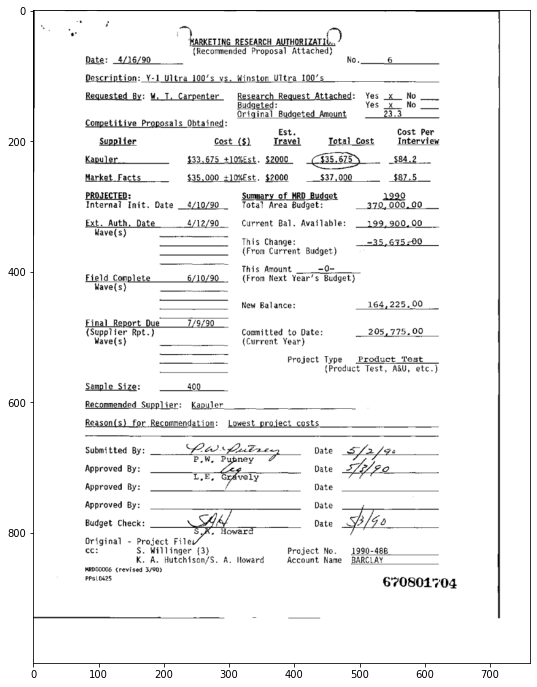

Ответ:  


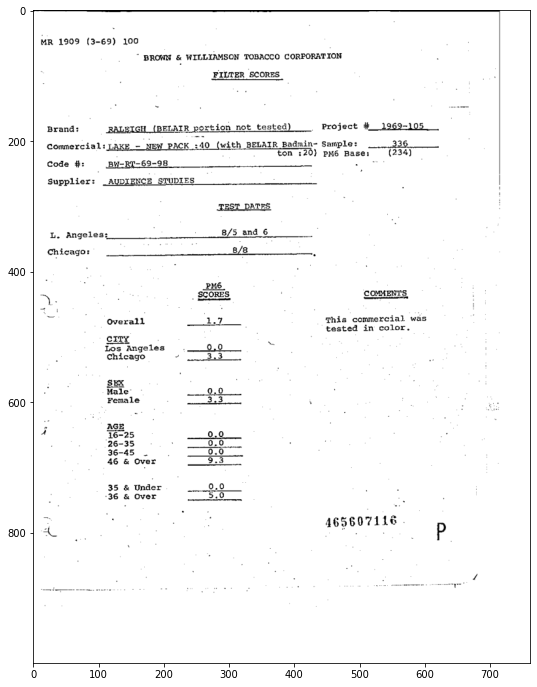

Ответ:  


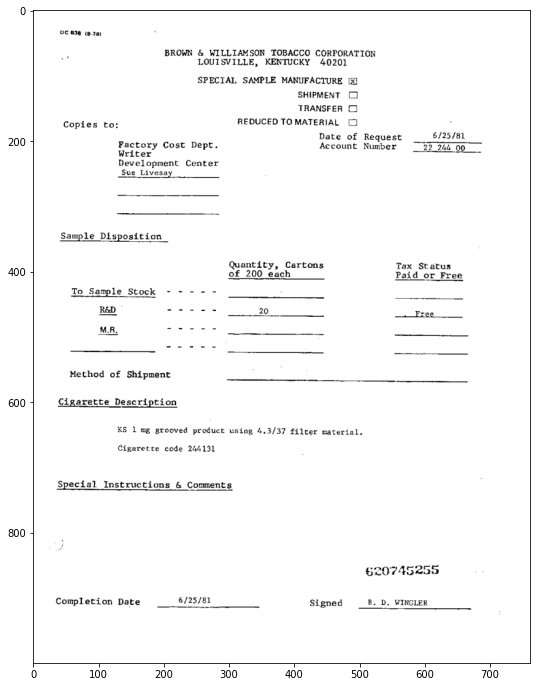

Ответ:  


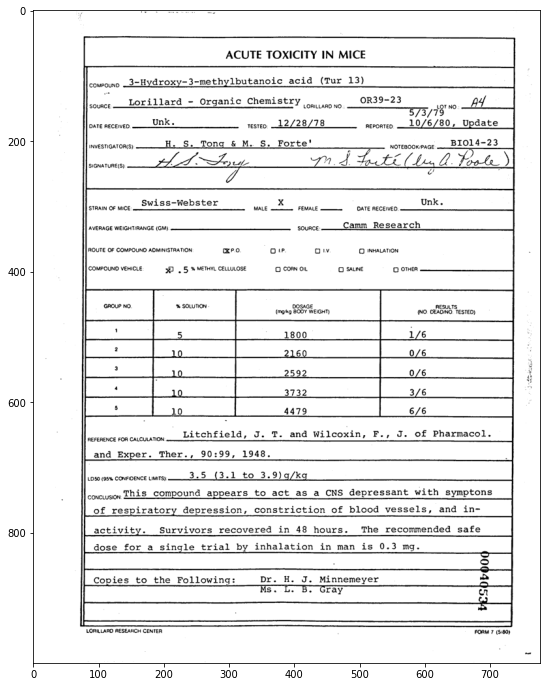

In [54]:
test = open_anatac(data_path_train)
# test = open_anatac(data_path_test)
for i in range(9, 15):
    fig,ax = plt.subplots(figsize=(12, 12))
    img_path = (images_path_train + '/' + str(test.loc[i, 'fil_name' ]) + '.png')
#     img_path = (images_path_test + '/' + str(test.loc[i, 'fil_name' ]) + '.png')
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    print('Ответ: ', num_to_label(decoded[0]))
    plt.show()